In [3]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [4]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import *
import time
import os
import gdown
from zipfile import ZipFile

In [7]:
os.makedirs("celeba")

In [8]:
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba/data.zip", "r") as zipobj:
    zipobj.extractall("celeba")

In [9]:
batch_size = 32

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "celeba", label_mode=None, image_size=(64, 64), validation_split=0.2, batch_size=batch_size, subset="training", seed=741
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "celeba", label_mode=None, image_size=(64, 64), validation_split=0.2, batch_size=batch_size, subset="validation", seed=741
)


train_dataset = train_dataset.map(lambda x: x / 255.0)
test_dataset = test_dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


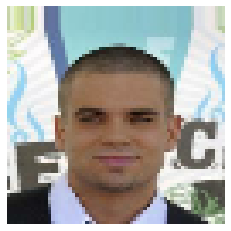

In [14]:
for x in test_dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [15]:
class VAE(tf.keras.Model):


  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Sequential(
        [
            layers.InputLayer(input_shape=(64, 64, 3)),
            layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Flatten(),
            # No activation
            layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = Sequential(
        [
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=8*8*32, activation=tf.nn.relu),
            layers.Reshape(target_shape=(8, 8, 32)),
            layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same',activation='relu'),
            layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same', activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [16]:
#Verifiyng that input and output shapes match
vae = VAE(100)
vae.encoder.summary(), vae.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

(None, None)

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [19]:
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

In [20]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 17, Test set ELBO: -6218.83203125, time elapse for current epoch: 156.05150508880615


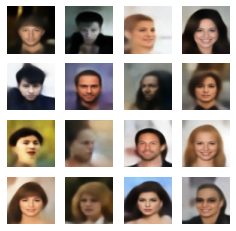

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  generate_and_save_images(model, epoch, test_sample)

In [1]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [2]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

NameError: ignored

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=64):
  """Plots n x n digit images decoded from the latent space."""

  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width, 3))

  for i in range(n):
    for j in range(n):
      x_decoded = model.sample()
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size, :] = x_decoded.numpy()[0]

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [ ]:
plot_latent_images(model, 10)